## Predict the occupancy in a public Library.

In the region of Lechi, recent improvements on mental health of the population have increased the use of the public
library.<br>
In order to face this new scenario, regional government has decided to reorganize the staff and the activities carried
out in the library. The library director believes that library occupancy is influenced by the weather conditions, type
of day (weekend, workday) and the library staff.
In this assignment, you will use regression techniques in order to predict the use of the library by using climatic,
temporal and employees information.
Your prediction will be evaluated according to the Mean Absolute Error (MAE) metric.

First let's import the libraries for this assignment.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import sklearn as sk
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

C:\Users\domenicoboris.salvat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Let's import the dataset located in the working directory and print its size and top 5 records.

In [2]:
# Loading the dataset with pandas
dir = %pwd
data = pd.read_csv('{}\\train2.csv'.format(dir))

In [3]:
print('Dataset size : ', data.shape)
data.head(5)

Dataset size :  (10427, 15)


,Unnamed: 0,dteday,hr,holiday,weekday,workingday,season_t,weather,temperature,s_temp,humidity,winds,n_employee,exp_employee,occupancy
0,0,2011-05-19,1,0,4,1,summer,Clear,20.50,24.240,94,0.0,2.67,9.29,6
1,1,2012-08-19,18,0,0,0,fall,Cloudy,26.24,29.545,78,7.0,2.67,3.57,377
2,2,2011-09-24,8,0,6,0,winter,Cloudy,23.78,27.275,90,6.0,2.67,28.00,121
3,3,2012-11-05,4,0,1,1,winter,Cloudy,12.30,14.395,52,17.0,2.67,4.57,16
4,4,2011-11-12,0,0,6,0,winter,Clear,9.84,12.120,60,9.0,1.67,7.57,64


## Removing additional index-column
The .csv file containing training data, has an additional columns "Unnamed : 0" with the indexes of each record. Since we don't need this column (as Pandas has already an index column) we will remove it from the dataset.

In [4]:
# Cleaning Data : Removing Index Column
print('Original columns :\n' , list(data.columns))
data.drop(data.columns[0], axis = 1, inplace= True)
data.head(5)

Original columns :
 ['Unnamed: 0', 'dteday', 'hr', 'holiday', 'weekday', 'workingday', 'season_t', 'weather', 'temperature', 's_temp', 'humidity', 'winds', 'n_employee', 'exp_employee', 'occupancy']


,dteday,hr,holiday,weekday,workingday,season_t,weather,temperature,s_temp,humidity,winds,n_employee,exp_employee,occupancy
0,2011-05-19,1,0,4,1,summer,Clear,20.50,24.240,94,0.0,2.67,9.29,6
1,2012-08-19,18,0,0,0,fall,Cloudy,26.24,29.545,78,7.0,2.67,3.57,377
2,2011-09-24,8,0,6,0,winter,Cloudy,23.78,27.275,90,6.0,2.67,28.00,121
3,2012-11-05,4,0,1,1,winter,Cloudy,12.30,14.395,52,17.0,2.67,4.57,16
4,2011-11-12,0,0,6,0,winter,Clear,9.84,12.120,60,9.0,1.67,7.57,64


Now let's explore the dataset using .describe() funcionality in pandas. <br>
#### No missing Values
From the count of each variable we don't reveal the presence of missing values.<br>
#### Datetime
__dteday__ it's a datetime variable counting 731 days (roughly 2 years of data).
#### Categorical Variables
__season__ and __weather__ are two __categorical string variables__ with 4 categories each.<br>
__hr__ and __weekday__ are also categorical variables but with integer values. <br> 
#### Binary Variables
__holiday__ and __workingday__ are two binary variables. 
<br>The other variables contains numerical values and __occupancy__ is the target of analysis.

In [5]:
# Exploring Data :
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10427 entries, 0 to 10426
Data columns (total 14 columns):
dteday          10427 non-null object
hr              10427 non-null int64
holiday         10427 non-null int64
weekday         10427 non-null int64
workingday      10427 non-null int64
season_t        10427 non-null object
weather         10427 non-null object
temperature     10427 non-null float64
s_temp          10427 non-null float64
humidity        10427 non-null int64
winds           10427 non-null float64
n_employee      10427 non-null float64
exp_employee    10427 non-null float64
occupancy       10427 non-null int64
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


,hr,holiday,weekday,workingday,temperature,s_temp,humidity,winds,n_employee,exp_employee,occupancy
count,10427.000000,10427.000000,10427.000000,10427.000000,10427.000000,10427.000000,10427.000000,10427.000000,10427.000000,10427.000000,10427.000000
mean,11.586171,0.026949,3.002302,0.680253,20.414831,23.847285,62.713820,12.713916,2.336256,15.134561,191.480100
std,6.920372,0.161943,2.014953,0.466401,7.901815,8.603002,19.345313,8.182245,0.467820,8.806866,183.072824
min,0.000000,0.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,1.670000,0.000000,1.000000
25%,6.000000,0.000000,1.000000,0.000000,13.940000,16.665000,48.000000,7.000000,2.000000,7.430000,40.000000
50%,12.000000,0.000000,3.000000,1.000000,20.500000,24.240000,63.000000,11.000000,2.330000,15.000000,145.000000
75%,18.000000,0.000000,5.000000,1.000000,27.060000,31.060000,79.000000,17.000000,2.670000,22.860000,282.000000
max,23.000000,1.000000,6.000000,1.000000,41.000000,49.240000,100.000000,57.000000,3.000000,30.290000,976.000000


## Correcting data types
Dteday column has "object" type, we need to convert it in a date time format.

In [6]:
data['dteday'] = pd.to_datetime(data['dteday'], format='%Y-%m-%d')
data.info()
data['occupancy'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10427 entries, 0 to 10426
Data columns (total 14 columns):
dteday          10427 non-null datetime64[ns]
hr              10427 non-null int64
holiday         10427 non-null int64
weekday         10427 non-null int64
workingday      10427 non-null int64
season_t        10427 non-null object
weather         10427 non-null object
temperature     10427 non-null float64
s_temp          10427 non-null float64
humidity        10427 non-null int64
winds           10427 non-null float64
n_employee      10427 non-null float64
exp_employee    10427 non-null float64
occupancy       10427 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(6), object(2)
memory usage: 1.1+ MB


count    10427.000000
mean       191.480100
std        183.072824
min          1.000000
25%         40.000000
50%        145.000000
75%        282.000000
max        976.000000
Name: occupancy, dtype: float64

## Data Exploration

### Date & Yearly increase
From the observation of daily average occupancy over the time, we see two cycles with peak during summer and minimum during winter (January). <br>
__The overall trend it's increasing YoY__ by 66%.

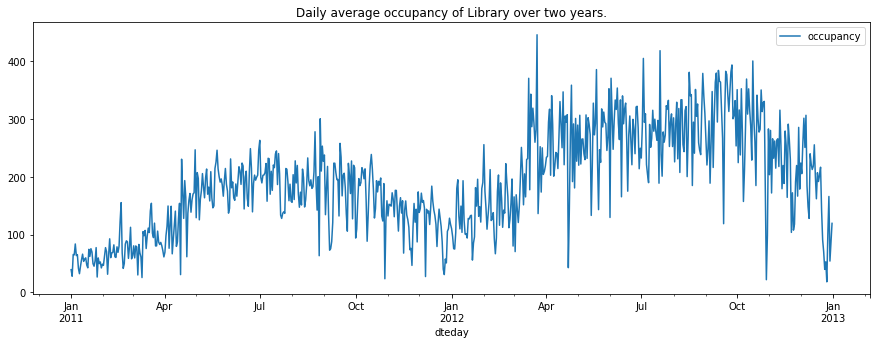

In [7]:
# Occupancy Distribution over time
data[['dteday','occupancy']].groupby('dteday').mean().plot(kind = 'line', 
                                                           figsize=(15,5),
                                                           title = 'Daily average occupancy of Library over two years.')

In [8]:
year = data['dteday'].dt.year
data['year'] = year
print(data[['year','occupancy']].groupby('year').mean())
print('delta YoY : ', 238.7 / 143.5 -1 ) 

       occupancy
year            
2011  143.568199
2012  238.707675
delta YoY :  0.6634146341463414


### Monthly & Season
The months with lower occupancy are January, February and December (winter), while summer months have higher occupancy.<br>
__Surprisingly, the _season_ variable tells that it's spring rather than winter, the season with lower occupancy.__

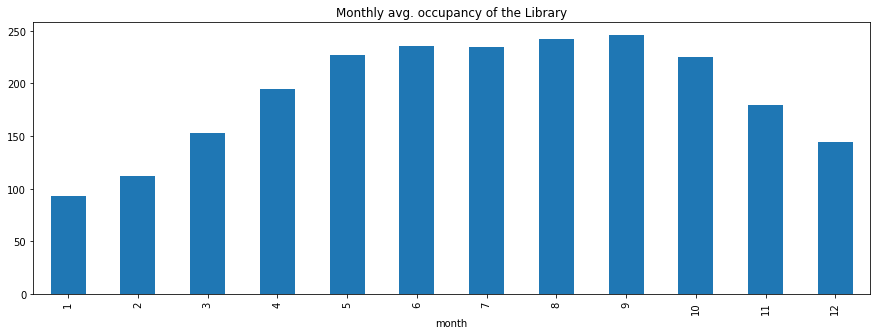

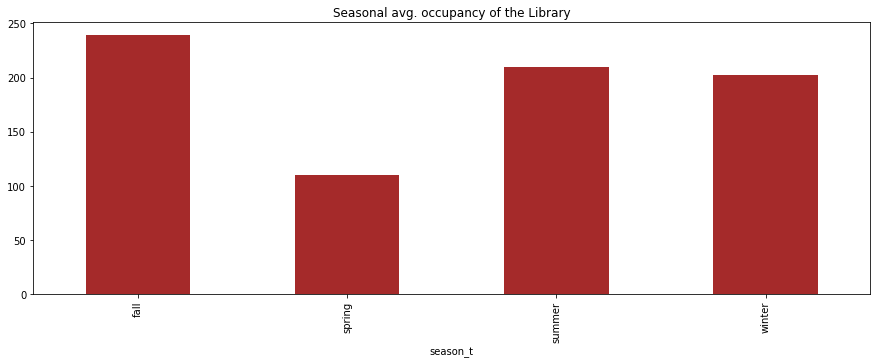

In [9]:
month = data['dteday'].dt.month
data['month'] = month
data[['month','occupancy']].groupby('month').mean().plot(kind = 'bar',
                                                        figsize = (15,5),
                                                        title = 'Monthly avg. occupancy of the Library',
                                                        legend = False)
data[['season_t','occupancy']].groupby('season_t').mean().plot(kind = 'bar',
                                                        figsize = (15,5),
                                                        title = 'Seasonal avg. occupancy of the Library',
                                                        color = 'brown',
                                                        legend = False)


### Hour of the day
From the next figure, we see that the hourly average occupancy of the Library is bi-modal, with peaks in the afternoon [16-19] and in the morning [7-9]. There is some presence in the evening and late night hours (probably staff members).

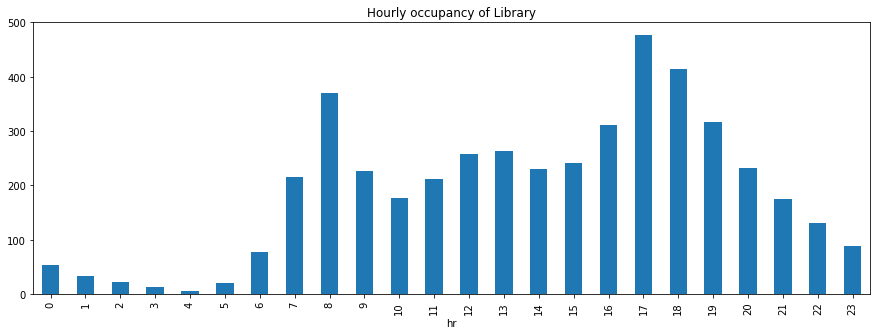

In [10]:
# Occupancy Distribution hourly
data[['hr','occupancy']].groupby('hr').mean().plot(kind = 'bar',
                                                  figsize = (15,5),
                                                  title = 'Hourly occupancy of Library',
                                                  legend = False
                                                  )

### Day of the week
__weekday__ is a numerical categorical variable where each number from 0-6 correspond to a day of the week from Sunday (0) to Saturday (6).<br>
Sunday and Monday have lower occupancy compared to the other days of the week, including Saturday.

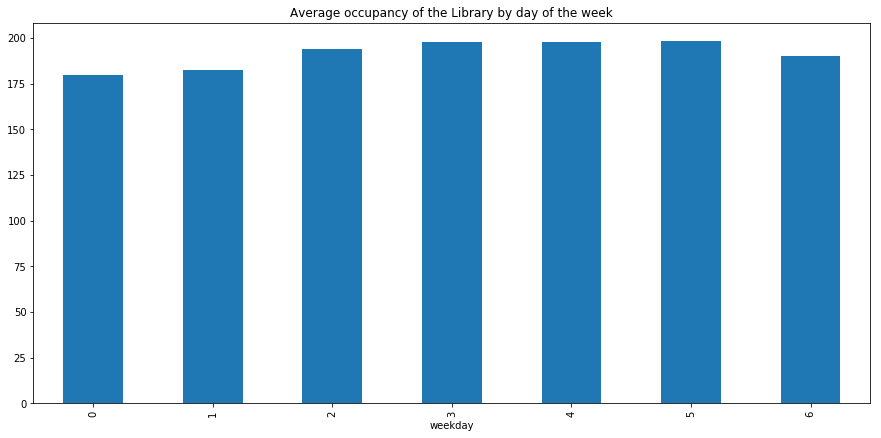

In [11]:
# Occupancy Distribution during weekdays
data[['weekday','occupancy']].groupby('weekday').mean().plot(kind = 'bar',
                                                  figsize = (15,7),
                                                  title = 'Average occupancy of the Library by day of the week',
                                                  legend = False)

### Weekends & Holidays
The next two figures confirm the assumption that the occupancy of the library is on average higher during working days and significantly lower during holidays. 

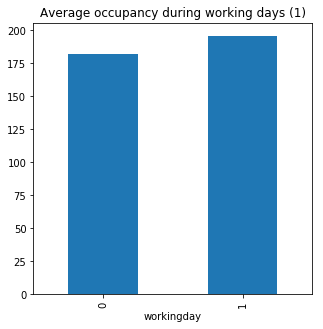

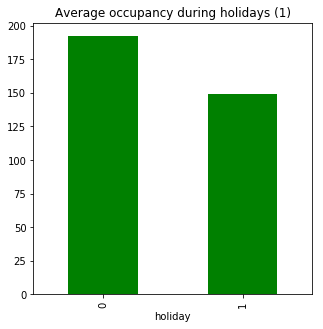

In [12]:
# Occupancy Distributiond during workday & holidays
data[['workingday','occupancy']].groupby('workingday').mean().plot(kind = 'bar',
                                                                   figsize = (5,5),
                                                                   title = 'Average occupancy during working days (1)',
                                                                   legend = False)
data[['holiday','occupancy']].groupby('holiday').mean().plot(kind = 'bar',
                                                             figsize = (5,5),
                                                             title = 'Average occupancy during holidays (1)',
                                                             color = 'green',
                                                             legend = False)

### Boxplots of Seasons and Weather conditions

Using Boxplot, we see that the mean occupancy of the library in Fall is higher compared to the other seasons. Spring, on the other hand, has a lower mean and the distribution of values is more compact. Summer and Winter distributions are pretti much similar. There is the presence of outliers in all the seasons. 

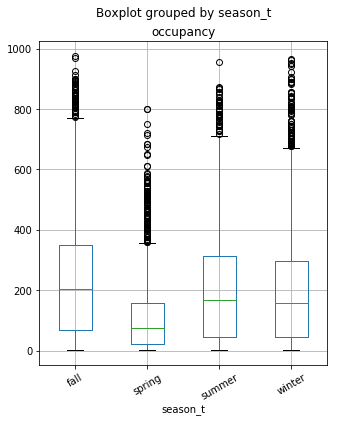

In [13]:
# Exploring Seasons
data.boxplot('occupancy','season_t', rot = 30, figsize=(5,6))

For what concers weather conditions, we notice that during "clear" days, there is a big variability of library occupation, compared to "LightRain" and "Snow". In this case we have a very compact Boxplot, with no outliers. Snow weather conditions results a good marker of library occupancy.

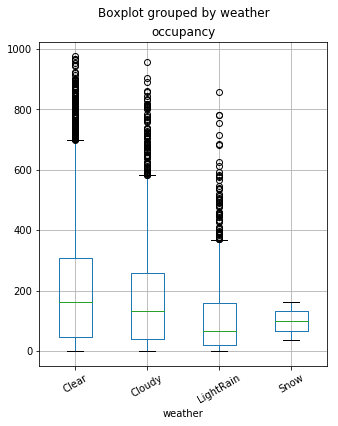

In [14]:
# Exploring Weather
data.boxplot('occupancy','weather', rot = 30, figsize=(5,6))

### Heatmap of Correlations for numerical variables

To understand the correlations of _occupancy_ and the other numerical variables, let's plot an heatmap.<br>
__Temperature__<br>
The figure shows that _occupancy_ is positively correlated to the external _temperature_ and perceived temperature _sTemp_.
However _temperature_ and _stemperature_ are directly correlated. To __avoid multicollinearity__ we will pick only one dimension, in this case _temperature_.<br>
__Humidity__<br>
There is a negative correlations between _occupancy_ of the library and levels of humidity.<br>
__Wind__<br>
There is a weak positive correlations between winds and occupancy.<br>
__Employees__<br>
There is no correlations between the number and the experience of the employees and the occupancy of the library.

              occupancy  temperature    s_temp  humidity     winds  \
occupancy      1.000000     0.405264  0.402489 -0.324504  0.089091   
temperature    0.405264     1.000000  0.989680 -0.075741 -0.022414   
s_temp         0.402489     0.989680  1.000000 -0.060052 -0.060224   
humidity      -0.324504    -0.075741 -0.060052  1.000000 -0.295253   
winds          0.089091    -0.022414 -0.060224 -0.295253  1.000000   
n_employee    -0.003997    -0.013608 -0.013551 -0.013365  0.006372   
exp_employee  -0.001944    -0.027093 -0.026548  0.000306  0.010031   

              n_employee  exp_employee  
occupancy      -0.003997     -0.001944  
temperature    -0.013608     -0.027093  
s_temp         -0.013551     -0.026548  
humidity       -0.013365      0.000306  
winds           0.006372      0.010031  
n_employee      1.000000     -0.013474  
exp_employee   -0.013474      1.000000  


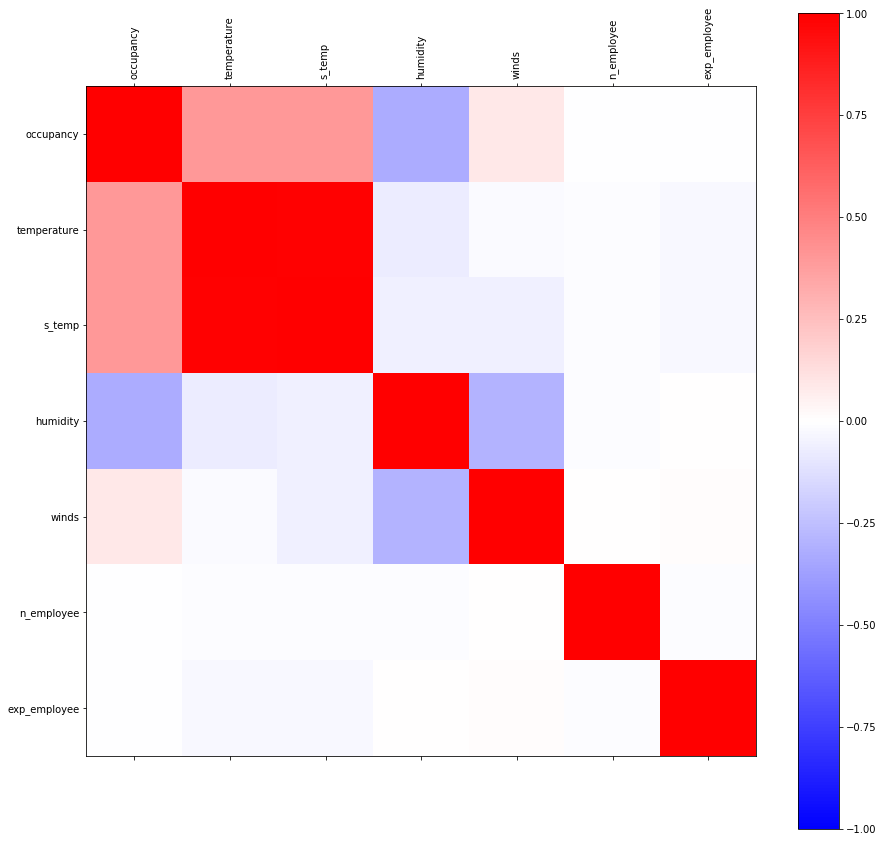

In [15]:
# Heatmap correlations
#numerical_variables = ['temperature', 's_temp', 'humidity', 'winds', 'n_employee', 'exp_employee']
data_to_corr = data[['occupancy','temperature', 's_temp', 'humidity', 'winds', 'n_employee', 'exp_employee']]
correlations = data_to_corr.corr()

print(correlations)

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap = 'bwr')
fig.colorbar(cax)
ticks = np.arange(0,7,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(list(data_to_corr.columns.values),rotation='vertical')
ax.set_yticklabels(list(data_to_corr.columns.values) )

plt.show()

## Data Preparation

From the dataset exploration, we can conclude that the dataset should be worked, as follow (__dataprep__):

__1 - Add an Year Colum__  since there is an YoY +66% overall increase in Occupancy.<br>
__2 - Divide Hours in bins__ according to the peak hours :
    - "hr_7_9" 1st peak.
    - "hr_10_15" normal affluence. 
    - "hr_16-19" highest peak.
    - "hr_20_22" late hours.
    - "hr_23-06" night hours.
__3 - Create 4 new season binary variables__ from datetime, according to the meteorological season as follows :
    - "is_spring" from march till may [3,4,5]
    - "is_summer" from june till august [6,7,8]
    - "is_fall" from september till november [9,10,11]
    - "is_winter" from december till february [12,1,2]
__4 - Drop perceived temperature "s_temp"__ to avoid multicollinearity with __temperature__.<br>
__5 - One hot encode Weather variable.__
    

## Data Preparation pipeline

In [16]:
# New part of day binary variables
hr_7_9 = (data['hr'] >= 7)&(data['hr'] < 10)
hr_7_9.replace({False : 0, True :1}, inplace = True)

hr_10_15 = (data['hr'] >= 10)&(data['hr'] < 16)
hr_10_15.replace({False : 0, True :1}, inplace = True)

hr_16_19 = (data['hr'] >= 16)&(data['hr'] < 20)
hr_16_19.replace({False : 0, True :1}, inplace = True)

hr_20_22 = (data['hr'] >= 20)&(data['hr'] < 23)
hr_20_22.replace({False : 0, True :1}, inplace = True)

hr_23_06 = (data['hr'] >= 23)|(data['hr'] < 7)
hr_23_06.replace({False : 0, True :1}, inplace = True)

In [17]:
# New Season binary variabels
is_winter = (data['month'] == 1)|(data['month'] == 2)|(data['month'] == 12)
is_winter.replace({False : 0, True :1}, inplace = True)

is_spring = (data['month'] == 3)|(data['month'] == 4)|(data['month'] == 5)
is_spring.replace({False : 0, True :1}, inplace = True)

is_summer = (data['month'] == 6)|(data['month'] == 7)|(data['month'] == 8)
is_summer.replace({False : 0, True :1}, inplace = True)

is_fall = (data['month'] == 9)|(data['month'] == 10)|(data['month'] == 11)
is_fall.replace({False : 0, True :1}, inplace = True)

In [18]:
# Columns added to Dataset
data['hr_7_9'] = hr_7_9
data['hr_10_15'] = hr_10_15
data['hr_16_19'] = hr_16_19
data['hr_20_22'] = hr_20_22
data['hr_23_06'] = hr_23_06
data['is_winter'] = is_winter
data['is_spring'] = is_spring
data['is_summer'] = is_summer
data['is_fall'] = is_fall

In [19]:
# Weather binary encoded variables
data = pd.get_dummies(data, columns=['weather'])

In [20]:
# Dataset Clean 
data_clean = data[['year', 'month', 'is_winter','is_spring','is_summer','is_fall', # year, month and season 
                   'hr',
                   'hr_7_9','hr_10_15','hr_16_19','hr_20_22','hr_23_06', # part of the day
                   'holiday','workingday','weekday',  # type of day       
                   'weather_Cloudy','weather_Clear','weather_LightRain','weather_Snow', # weather conditions
                   'temperature','humidity','winds', # numerical variables
                   'occupancy' # target
                  ]]
data_clean.head(5)
print(data_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10427 entries, 0 to 10426
Data columns (total 23 columns):
year                 10427 non-null int64
month                10427 non-null int64
is_winter            10427 non-null int64
is_spring            10427 non-null int64
is_summer            10427 non-null int64
is_fall              10427 non-null int64
hr                   10427 non-null int64
hr_7_9               10427 non-null int64
hr_10_15             10427 non-null int64
hr_16_19             10427 non-null int64
hr_20_22             10427 non-null int64
hr_23_06             10427 non-null int64
holiday              10427 non-null int64
workingday           10427 non-null int64
weekday              10427 non-null int64
weather_Cloudy       10427 non-null uint8
weather_Clear        10427 non-null uint8
weather_LightRain    10427 non-null uint8
weather_Snow         10427 non-null uint8
temperature          10427 non-null float64
humidity             10427 non-null int64
winds  

### Training & Test set

In [21]:
# Divide the X matrix and target vector
X = data_clean.drop('occupancy',axis = 1)
y = data_clean['occupancy']

In [22]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [23]:
# Check of numerosity
print('Training set X')
print(np.shape(X_train))
print('Training set y')
print(np.shape(y_train))
print('Test set X')
print(np.shape(X_test))
print('Test set y')
print(np.shape(y_test))

Training set X
(8341, 22)
Training set y
(8341,)
Test set X
(2086, 22)
Test set y
(2086,)


### Model Selection

First we train a baseline Linear Regression model and calculate the mean absolute error.
The result is 84.

In [24]:
# LINEAR REGRESSION MODEL "lr"

regressor = LinearRegression() 
parameters = {'fit_intercept':[True,False], 
              'copy_X':[True, False]}

# Optimization & Cross Validation
gs_lr = GridSearchCV(regressor, parameters, cv=3 , scoring = 'neg_mean_absolute_error') 
gs_lr = gs_lr.fit(X_train,y_train)


print('***RESULTS***')
print("Best score: %f using %s" % (gs_lr.best_score_, gs_lr.best_params_))
means = gs_lr.cv_results_['mean_test_score']
stds = gs_lr.cv_results_['std_test_score']
params = gs_lr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Test
gs_lr.score(X_test, y_test)

***RESULTS***
Best score: -83.296712 using {'copy_X': True, 'fit_intercept': True}
-83.296712 (0.456439) with: {'copy_X': True, 'fit_intercept': True}
-91.839813 (11.780492) with: {'copy_X': True, 'fit_intercept': False}
-83.296712 (0.456439) with: {'copy_X': False, 'fit_intercept': True}
-91.839813 (11.780492) with: {'copy_X': False, 'fit_intercept': False}


-83.17151238419234

In [25]:
# Optimal Linear Regression
regressor_opt = LinearRegression(copy_X = True, fit_intercept = True) 
lr = regressor_opt.fit(X_train,y_train)

# Evaluation on Test Set via Mean Absolute Error
print("MAE train: ", mean_absolute_error(y_train, lr.predict(X_train)))
print("MAE test: ", mean_absolute_error(y_test, lr.predict(X_test)))

MAE train:  83.07716713801784
MAE test:  83.17151238419234


We then train a random forest classifier, and do a hyperparameters optimization using the grid search.

In [26]:
# RANDOM FOREST 'rf'

regressor = RandomForestRegressor(random_state = 42 , criterion = 'mae')

parameters = {# resampling with or withut repcement
              'bootstrap': [True, False],
              # Maximum number of levels in tree
              'max_depth': [5, 10, 50, None],
              # Number of features to consider at every split
              'max_features': [0.5, 'log2', 'auto', 'sqrt'],
              # Minimum number of samples required at each leaf node
              'min_samples_leaf': [1, 10, 50, 100],
              # Minimum number of samples required to split a node
              'min_samples_split': [2, 5, 10, 100],
              # Number of trees in random forest
              'n_estimators': [10, 50, 100]}
 
gs_rf = RandomizedSearchCV(regressor, parameters, cv=3, n_iter = 20, scoring = 'neg_mean_absolute_error', n_jobs = 20 ) 
gs_rf = gs_rf.fit(X_train,y_train)

print('***RESULTS***')
print("Best score: %f using %s" % (gs_rf.best_score_, gs_rf.best_params_))
means = gs_rf.cv_results_['mean_test_score']
stds = gs_rf.cv_results_['std_test_score']
params = gs_rf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***RESULTS***
Best score: -35.302961 using {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 0.5, 'max_depth': 50, 'bootstrap': False}
-35.302961 (0.697873) with: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 0.5, 'max_depth': 50, 'bootstrap': False}
-57.550798 (0.943643) with: {'n_estimators': 100, 'min_samples_split': 100, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
-35.641453 (0.792790) with: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 0.5, 'max_depth': None, 'bootstrap': False}
-52.102763 (1.405163) with: {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': True}
-71.776052 (1.128563) with: {'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}
-65.873642 (0.875115) with: {'n_estimat

### Optimal Model
The model with best performance in terms of MAE is a Random Forest Regressor with the following parameters:

In [27]:
gs_params = gs_rf.best_params_ 
gs_params

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_features': 0.5,
 'max_depth': 50,
 'bootstrap': False}

In [28]:
# Optimal Random Forest
random_opt = RandomForestRegressor(n_estimators = gs_params['n_estimators'],
                                  min_samples_split = gs_params['min_samples_split'],
                                  min_samples_leaf = gs_params['min_samples_leaf'],
                                  max_features = gs_params['max_features'],
                                  max_depth = gs_params['max_depth'],
                                  bootstrap = gs_params['bootstrap'],
                                  criterion = 'mae')
    
rf = random_opt.fit(X_train,y_train)

# Evaluation on Test Set via Mean Absolute Error

print("MAE train: ", mean_absolute_error(y_train, rf.predict(X_train)))
print("MAE test: ", mean_absolute_error(y_test, rf.predict(X_test)))

MAE train:  25.932125644407144
MAE test:  31.987739693192715


Random forest regressor has a signficant lower Mean Absolute Error compared to baseline model.<br>
Since there is a narrow range of values between "Train" and "Test" _mae_, we can conclude that the model is not overfitting data.

### Model Interpretation

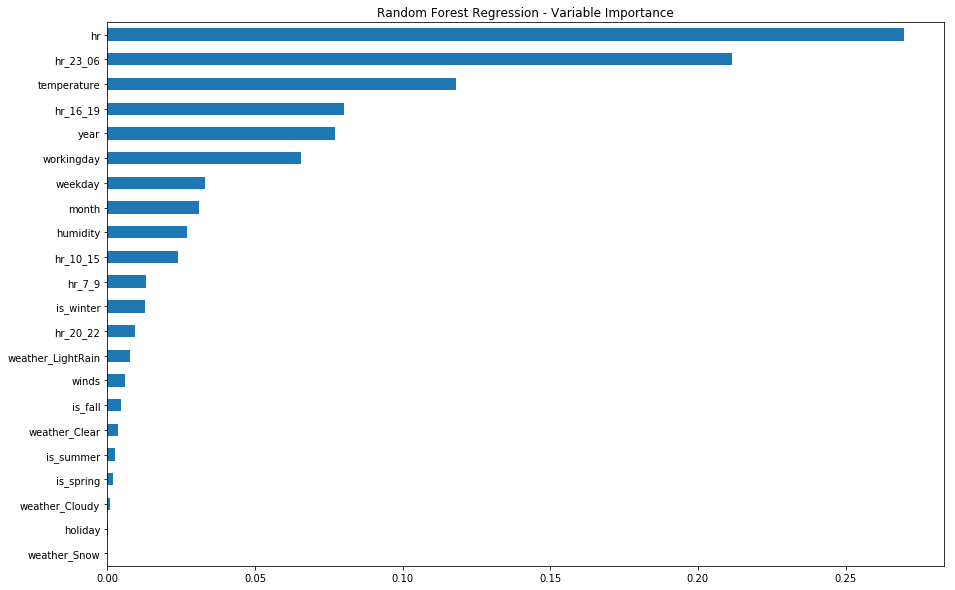

In [29]:
# Feature Importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=True)
# Plot Horizontal Bars
feature_importances.plot(kind = 'barh',
                        figsize = (15,10),
                        title = 'Random Forest Regression - Variable Importance',
                        legend = False)

### TOP Random Forest Variables
The top 5 more relevant variables in the Random Forest model are :

    - "HR", since there are some peak hours.
    - "hr_23_06", night time, when the occupancy is lower.
    - "temperature", external temperature is positively correlated to the occupancy of the library.
    - "hr_16_09", the afternoon time, when the occupancy is higher.
    - "year", due to the yearly increase of the occupancy in the library.

## Validation

In [57]:
# Loading the validation set with pandas

dir = %pwd
validation = pd.read_csv('{}\\test_explanatory.csv'.format(dir))
validation.head(5)

,Unnamed: 0,dteday,hr,holiday,weekday,workingday,season_t,weather,temperature,s_temp,humidity,winds,n_employee,exp_employee
0,0,2012-06-23,19,0,6,0,fall,Clear,32.80,34.850,27,13.0,2.67,1.14
1,1,2012-01-02,20,1,1,0,spring,Clear,9.84,11.365,41,15.0,2.67,20.00
2,2,2011-10-28,2,0,5,1,winter,Clear,13.12,15.150,66,19.0,2.00,28.86
3,3,2012-05-29,19,0,2,1,summer,Clear,31.98,35.605,52,24.0,2.00,2.29
4,4,2011-01-20,0,0,4,1,spring,Clear,10.66,11.365,56,26.0,3.00,16.43


In [58]:
# __0 - Removing Index Column __

print('Original columns :\n' , list(validation.columns))

#[year', 'month', 'is_winter','is_spring','is_summer','is_fall', # year, month and season 
#'hr',
#'hr_7_9','hr_10_15','hr_16_19','hr_20_22','hr_23_06', # part of the day
#'holiday','workingday','weekday',  # type of day       
#'weather_Cloudy','weather_Clear','weather_LightRain','weather_Snow', # weather conditions
#'temperature','humidity','winds', # numerical variables
#'occupancy' # target
#]

Original columns :
 ['Unnamed: 0', 'dteday', 'hr', 'holiday', 'weekday', 'workingday', 'season_t', 'weather', 'temperature', 's_temp', 'humidity', 'winds', 'n_employee', 'exp_employee']


In [59]:
validation.drop('Unnamed: 0', axis = 1, inplace= True)

In [60]:
validation.head(5)

,dteday,hr,holiday,weekday,workingday,season_t,weather,temperature,s_temp,humidity,winds,n_employee,exp_employee
0,2012-06-23,19,0,6,0,fall,Clear,32.80,34.850,27,13.0,2.67,1.14
1,2012-01-02,20,1,1,0,spring,Clear,9.84,11.365,41,15.0,2.67,20.00
2,2011-10-28,2,0,5,1,winter,Clear,13.12,15.150,66,19.0,2.00,28.86
3,2012-05-29,19,0,2,1,summer,Clear,31.98,35.605,52,24.0,2.00,2.29
4,2011-01-20,0,0,4,1,spring,Clear,10.66,11.365,56,26.0,3.00,16.43


In [61]:
# Convert date type
validation['dteday'] = pd.to_datetime(validation['dteday'], format='%Y-%m-%d')

In [62]:
# __1 - Add an Year and Month Colums __ 
year = validation['dteday'].dt.year
validation['year'] = year
month = validation['dteday'].dt.month
validation['month'] = month

In [63]:
validation.head(5)

,dteday,hr,holiday,weekday,workingday,season_t,weather,temperature,s_temp,humidity,winds,n_employee,exp_employee,year,month
0,2012-06-23,19,0,6,0,fall,Clear,32.80,34.850,27,13.0,2.67,1.14,2012,6
1,2012-01-02,20,1,1,0,spring,Clear,9.84,11.365,41,15.0,2.67,20.00,2012,1
2,2011-10-28,2,0,5,1,winter,Clear,13.12,15.150,66,19.0,2.00,28.86,2011,10
3,2012-05-29,19,0,2,1,summer,Clear,31.98,35.605,52,24.0,2.00,2.29,2012,5
4,2011-01-20,0,0,4,1,spring,Clear,10.66,11.365,56,26.0,3.00,16.43,2011,1


In [64]:
# __2 - Divide Hours in bins__ 

hr_7_9 = (validation['hr'] >= 7)&(validation['hr'] < 10)
hr_7_9.replace({False : 0, True :1}, inplace = True)

hr_10_15 = (validation['hr'] >= 10)&(validation['hr'] < 16)
hr_10_15.replace({False : 0, True :1}, inplace = True)

hr_16_19 = (validation['hr'] >= 16)&(validation['hr'] < 20)
hr_16_19.replace({False : 0, True :1}, inplace = True)

hr_20_22 = (validation['hr'] >= 20)&(validation['hr'] < 23)
hr_20_22.replace({False : 0, True :1}, inplace = True)

hr_23_06 = (validation['hr'] >= 23)|(validation['hr'] < 7)
hr_23_06.replace({False : 0, True :1}, inplace = True)

In [65]:
#__3 - Create 4 new season binary variables__ 

is_winter = (validation['month'] == 1)|(validation['month'] == 2)|(validation['month'] == 12)
is_winter.replace({False : 0, True :1}, inplace = True)

is_spring = (validation['month'] == 3)|(validation['month'] == 4)|(validation['month'] == 5)
is_spring.replace({False : 0, True :1}, inplace = True)

is_summer = (validation['month'] == 6)|(validation['month'] == 7)|(validation['month'] == 8)
is_summer.replace({False : 0, True :1}, inplace = True)

is_fall = (validation['month'] == 9)|(validation['month'] == 10)|(validation['month'] == 11)
is_fall.replace({False : 0, True :1}, inplace = True)

In [66]:
# Columns added to Dataset

validation['hr_7_9'] = hr_7_9
validation['hr_10_15'] = hr_10_15
validation['hr_16_19'] = hr_16_19
validation['hr_20_22'] = hr_20_22
validation['hr_23_06'] = hr_23_06
validation['is_winter'] = is_winter
validation['is_spring'] = is_spring
validation['is_summer'] = is_summer
validation['is_fall'] = is_fall

In [67]:
#__4 - Drop perceived temperature "s_temp"__ 
#__5 - One hot encode Weather variable__
validation = pd.get_dummies(validation, columns=['weather'])

In [71]:
# Validation Clean 
validation_clean = validation[['year', 'month', 'is_winter','is_spring','is_summer','is_fall', # year, month and season 
                   'hr',
                   'hr_7_9','hr_10_15','hr_16_19','hr_20_22','hr_23_06', # part of the day
                   'holiday','workingday','weekday',  # type of day       
                   'weather_Cloudy','weather_Clear','weather_LightRain','weather_Snow', # weather conditions
                   'temperature','humidity','winds' 
                  ]]
validation_clean.head(5)
print(validation_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6952 entries, 0 to 6951
Data columns (total 22 columns):
year                 6952 non-null int64
month                6952 non-null int64
is_winter            6952 non-null int64
is_spring            6952 non-null int64
is_summer            6952 non-null int64
is_fall              6952 non-null int64
hr                   6952 non-null int64
hr_7_9               6952 non-null int64
hr_10_15             6952 non-null int64
hr_16_19             6952 non-null int64
hr_20_22             6952 non-null int64
hr_23_06             6952 non-null int64
holiday              6952 non-null int64
workingday           6952 non-null int64
weekday              6952 non-null int64
weather_Cloudy       6952 non-null uint8
weather_Clear        6952 non-null uint8
weather_LightRain    6952 non-null uint8
weather_Snow         6952 non-null uint8
temperature          6952 non-null float64
humidity             6952 non-null int64
winds                6952 non-

In [72]:
# Prediction
target = random_opt.predict(validation_clean)

In [77]:
len(target)
#len(validation)

6952

In [78]:
target_export = pd.DataFrame(target, columns = ['target'])
target_export

,target
0,425.055
1,103.785
2,9.585
3,526.940
4,12.865
5,31.470
6,755.235
7,143.885
8,8.890
9,25.470


In [79]:
target_export.to_csv('target.csv',sep=',')